# Fine-tuning OpenCLIP on a Hugging Face image–text dataset (ViT-B-32)

This notebook shows an end-to-end, **single-GPU** fine-tuning run of an OpenCLIP model (`ViT-B-32`) on a **Hugging Face image–text dataset**.

**Dataset used:** `keremberke/food-101-with-captions` (easy to download, already has captions).

You can swap the dataset with another HF dataset that has an `image` column and a `caption`/`text` column.


In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import get_linear_schedule_with_warmup
from PIL import Image
from tqdm.auto import tqdm
import open_clip
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Setup Device
print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch: 2.5.1+cu121
cuda available: True
Using device: cuda


## Load a dataset from Hugging Face

We'll use a **small subset** by default so it runs quickly. Increase `train_samples` and `eval_samples` if you want.


In [3]:
dataset_id = "mdwiratathya/ROCO-radiology"
print(f"Loading dataset: {dataset_id}")
ds = load_dataset(dataset_id)
ds

Loading dataset: mdwiratathya/ROCO-radiology


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'caption'],
        num_rows: 65419
    })
    validation: Dataset({
        features: ['image', 'image_id', 'caption'],
        num_rows: 8175
    })
    test: Dataset({
        features: ['image', 'image_id', 'caption'],
        num_rows: 8176
    })
})

In [4]:
print(ds['test'].column_names)
sample = ds['test'][0]
sample

['image', 'image_id', 'caption']


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=694x478>,
 'image_id': 'ROCO_00001',
 'caption': ' Axial MRI (coronal view).\n'}

In [5]:
# Split with no overlap using indices
train_samples = 7000
eval_samples = 1000
indices = list(range(len(ds['test'])))
random.shuffle(indices)

train_indices = indices[:train_samples]
eval_indices = indices[train_samples : train_samples + eval_samples]
test_indices = indices[train_samples + eval_samples:]

train_split = ds['test'].select(train_indices)
eval_split = ds['test'].select(eval_indices)
test_split = ds['test'].select(test_indices)

print(f"Train size: {len(train_split)}, Eval size: {len(eval_split)}, Test size: {len(test_split)}")

Train size: 7000, Eval size: 1000, Test size: 176


## Create the OpenCLIP model + tokenizer


In [6]:
# Configuration
batch_size = 32 if device == 'cuda' else 16
epochs = 5  # Increased slightly as we have better optimization
lr = 5e-6
weight_decay = 0.1

In [7]:
# Model & Tokenizer
model_name = 'ViT-B-32'
pretrained = 'openai' #'laion2b_s34b_b79k'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)
model = model.to(device)
model.train()

# with torch.no_grad():
#     model.logit_scale.fill_(np.log(1/0.07)) # Reset to ~14.3 to see if it moves (100 is often max/saturated)
# model.logit_scale.requires_grad_(False)
print(f"Logit Scale requires_grad: {model.logit_scale.requires_grad}")


# PREVENT OVERFITTING: Freeze the Vision Encoder
# The dataset (2k images) is too small to fine-tune the heavy ViT backbone.
# We will only train the Text Encoder to align with the frozen images.
for param in model.visual.parameters():
    param.requires_grad = False

# LINEAR PROBING: Freeze the Text Transformer Backbone
# We only train the final projection steps to adapt the class embeddings.
# unfreeze last 2 blocks
for block in model.transformer.resblocks:
    for p in block.parameters():
        p.requires_grad = False

# Ensure Head is Trainable
model.text_projection.requires_grad_(True)
model.ln_final.requires_grad_(True)

# optional (I'd turn it OFF initially)
model.token_embedding.requires_grad_(False)
model.positional_embedding.requires_grad_(False)

model

c:\Users\jorge\Desktop\ComputerVisionProjects\finetuning-CLIP\.venv\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Logit Scale requires_grad: True


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

Let's check first how the pretrained model performs on a sample of the dataset

In [8]:
for n,p in model.named_parameters():
    if p.requires_grad:
        print(n)

text_projection
logit_scale
ln_final.weight
ln_final.bias


Text: intravascular coagulation manifestation
Similarity: [[0.283343]]


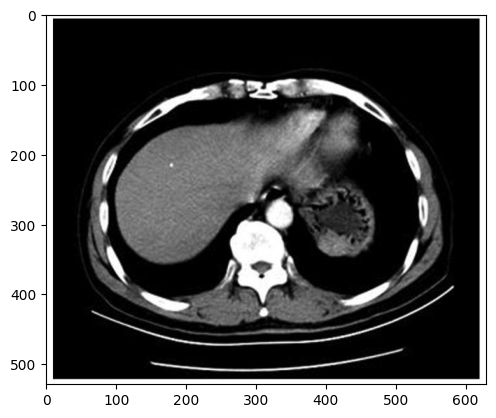

In [9]:
# image = Image.open("./examples/5.jfif").convert("RGB")
sample = test_split[0]
image = sample['image'].convert("RGB")
image_pre = preprocess(image)

text = "intravascular coagulation manifestation"
# text = sample['caption']

image_input = torch.tensor(np.expand_dims(image_pre, axis=0)).to(device)
text_tokens  = tokenizer(text).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

    # Normalize -> cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)

    # Similarity scores 
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

plt.imshow(image)
print("Text:", text)
print("Similarity:", similarity)

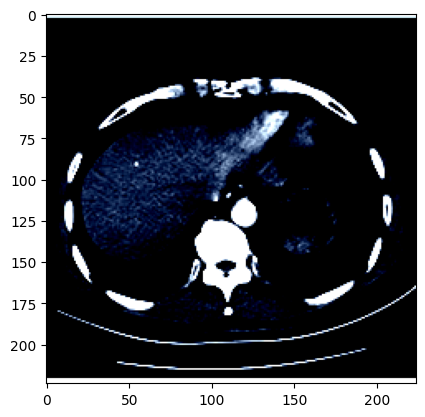

In [10]:
plt.imshow(image_pre.permute(1, 2, 0).numpy())

## Build a PyTorch Dataset + collate function


In [11]:
class HFImageTextDataset(Dataset):
    def __init__(self, hf_split):
        self.ds = hf_split

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex['image']
        if isinstance(img, Image.Image):
            img = img.convert('RGB')

        text = ex['caption']
        # Easier target text for low-res images:
        # text = (
        #     f"{ex['gender']} {ex['articleType']}, {ex['baseColour']}, "
        #     f"{ex['usage']} wear. {ex['productDisplayName']}"
        # )
        return img, str(text)

def collate_fn(batch):
    images, texts = zip(*batch)
    image_t = torch.stack([preprocess(im) for im in images], dim=0)
    text_t  = tokenizer(list(texts))
    return image_t, text_t.long()

train_ds = HFImageTextDataset(train_split)
eval_ds  = HFImageTextDataset(eval_split)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,
                          pin_memory=(device=='cuda'), collate_fn=collate_fn)
eval_loader  = DataLoader(eval_ds,  batch_size=batch_size, shuffle=False, num_workers=0,
                          pin_memory=(device=='cuda'), collate_fn=collate_fn)

images_b, text_b = next(iter(train_loader))
images_b.shape, text_b.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 77]))

In [12]:
batch = next(iter(train_loader))
images, text = batch
print(type(text))
if torch.is_tensor(text):
    print("tensor", text.dtype, text.shape)
else:
    print("not tensor:", getattr(text, "keys", lambda: None)())

<class 'torch.Tensor'>
tensor torch.int64 torch.Size([32, 77])


## Loss + quick retrieval metric

We use the standard symmetric CLIP contrastive loss.


In [13]:
def clip_contrastive_loss(logits_per_image, logits_per_text):
    """
    Standard CLIP contrastive loss.

    logits_per_image: [B, B] matrix
        Entry (i, j) = similarity between image i and text j

    logits_per_text: [B, B] matrix
        Entry (i, j) = similarity between text i and image j
        (usually the transpose of logits_per_image)

    Goal:
    - image i should match text i (diagonal)
    - all other pairs are negatives
    """

    # Batch size (number of image-text pairs)
    bs = logits_per_image.shape[0]

    # Ground-truth labels: image i corresponds to text i
    # Example for bs=4: [0, 1, 2, 3]
    labels = torch.arange(bs, device=logits_per_image.device, dtype=torch.long)
    
    # Image → Text loss:
    # For each image row, the correct text is at index i
    loss_i = nn.CrossEntropyLoss()(logits_per_image, labels)

    # Text → Image loss:
    # For each text row, the correct image is at index i
    loss_t = nn.CrossEntropyLoss()(logits_per_text, labels)

    # Symmetric CLIP loss
    return (loss_i + loss_t) / 2
    

@torch.no_grad()
def retrieval_recall_at_k(model, loader, k=5, max_batches=10):
    """
    Computes retrieval Recall@K for:
    - Image → Text
    - Text → Image

    Only uses a small subset of the data (max_batches) for speed.
    """

    # Switch to eval mode (disable dropout, etc.)
    was_training = model.training
    model.eval()

    imgs_all, txts_all = [], []

    # Encode a limited number of batches
    for bi, (images, text) in enumerate(loader):
        if bi >= max_batches:
            break

        images = images.to(device)
        text   = text.to(device)

        # Encode images and texts separately
        image_features = model.encode_image(images)
        text_features  = model.encode_text(text)

        # Normalize → cosine similarity
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)

        imgs_all.append(image_features)
        txts_all.append(text_features)

    if not imgs_all: return 0.0, 0.0

    # Concatenate all embeddings
    imgs = torch.cat(imgs_all, dim=0)  # [N, D]
    txts = torch.cat(txts_all, dim=0)  # [N, D]

    # Cosine similarity matrix
    # sims[i, j] = similarity(image_i, text_j)
    sims = imgs @ txts.T               # [N, N]

    # Extra log
    diag = sims.diag().mean().item()
    off  = (sims.sum() - sims.diag().sum()).item() / (sims.numel() - sims.size(0))
    print("diag_sim", diag, "offdiag_sim", off, "gap", diag-off)

    # For each image, find top-K most similar texts
    topk = sims.topk(k, dim=1).indices  # [N, K]
    # Ground truth: image i should match text i
    targets = torch.arange(sims.shape[0], device=sims.device).unsqueeze(1)
    # Check if correct text index appears in top-K
    i2t = (topk == targets).any(dim=1).float().mean().item()

    # For each text, find top-K most similar images
    topk_t = sims.topk(k, dim=0).indices  # [K, N]
    # Ground truth: text i should match image i
    targets_t = torch.arange(sims.shape[1], device=sims.device).unsqueeze(0)
    # Check if correct image index appears in top-K
    t2i = (topk_t == targets_t).any(dim=0).float().mean().item()

    # Restore training mode
    if was_training:
        model.train()

    return i2t, t2i


@torch.no_grad()
def diag_offdiag_gap_one_batch(model, loader):
    was_training = model.training
    model.eval()
    images, text = next(iter(loader))
    images, text = images.to(device), text.to(device)

    img_f = model.encode_image(images)
    txt_f = model.encode_text(text)
    img_f = img_f / img_f.norm(dim=-1, keepdim=True)
    txt_f = txt_f / txt_f.norm(dim=-1, keepdim=True)

    sims = img_f @ txt_f.T
    diag = sims.diag().mean().item()
    off  = (sims.sum() - sims.diag().sum()).item() / (sims.numel() - sims.size(0))

    if was_training:
        model.train()
    return diag, off, diag - off

## Fine-tune


In [ ]:
# Training Loop
# Add Weight Decay Separation
# We only decay weights in Linear/Conv2d layers, NOT biases or LayerNorms.

exclude = lambda n, p: p.ndim < 2 or "bn" in n or "ln" in n or "bias" in n or 'logit_scale' in n
include = lambda n, p: not exclude(n, p)

named_parameters = list(model.named_parameters())
gain_or_bias_params = [p for n, p in named_parameters if exclude(n, p) and p.requires_grad]
rest_params = [p for n, p in named_parameters if include(n, p) and p.requires_grad]

optimizer = torch.optim.AdamW(
                    [
                        {"params": gain_or_bias_params, "weight_decay": 0.},
                        {"params": rest_params, "weight_decay": weight_decay},
                    ],
                    lr=lr,
                )

# param_dict = {pn: p for pn, p in model.named_parameters()}
# decay_params = [p for n, p in param_dict.items() if p.requires_grad and "bias" not in n and "ln" not in n and "norm" not in n]
# nodecay_params = [p for n, p in param_dict.items() if p.requires_grad and ("bias" in n or "ln" in n or "norm" in n)]

# optim_groups = [
#     {"params": decay_params, "weight_decay": weight_decay},
#     {"params": nodecay_params, "weight_decay": 0.0},
# ]
# optimizer = torch.optim.AdamW(
#     [p for p in model.parameters() if p.requires_grad], 
#     lr=lr,
#     weight_decay=weight_decay)

# We need a linear warmup to avoid "shocking" the pre-trained weights
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.1 * total_steps), # 10% warmup
    num_training_steps=total_steps
)

scaler = torch.amp.GradScaler('cuda', enabled=(device=='cuda'))

print('Initial quick retrieval@5:', retrieval_recall_at_k(model, eval_loader, k=5, max_batches=50))

global_step = 0
for epoch in range(epochs):
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    running_loss = 0.0
    
    for images, text in pbar:
        images = images.to(device)
        text = text.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda', enabled=(device=='cuda')):
            logits_per_image, logits_per_text, logit_scale = model(images, text)
            loss = clip_contrastive_loss(logits_per_image,
                                         logits_per_text)

        scaler.scale(loss).backward()
        
        # Gradient Clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        scaler.step(optimizer)
        scaler.update()
        scheduler.step() # Step the scheduler

        running_loss += loss.item()
        global_step += 1
        
        if global_step % 10 == 0:
            pbar.set_postfix({'loss': running_loss / 10})
            running_loss = 0.0

    i2t, t2i = retrieval_recall_at_k(model, eval_loader, k=5, max_batches=50)
    diag, off, gap = diag_offdiag_gap_one_batch(model, eval_loader)
    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, text in eval_loader:
            images = images.to(device)
            text   = text.to(device)
            with torch.amp.autocast('cuda', enabled=(device=='cuda')):
                logits_per_image, logits_per_text = model(images, text)[:2]
                val_running_loss += clip_contrastive_loss(logits_per_image,
                                                          logits_per_text).item()

    val_loss_avg = val_running_loss / len(eval_loader)
    model.train()
    
    print(f'End of Epoch {epoch+1}: i2t={i2t:.6f}, t2i={t2i:.6f}, val_loss={val_loss_avg:.6f}')
    print("logit_scale:", float(model.logit_scale.exp().detach().cpu()))


diag_sim 0.3031316101551056 offdiag_sim 0.2680562124624625 gap 0.03507539769264312
Initial quick retrieval@5: (0.11000000685453415, 0.11800000816583633)


Epoch 1/5:   0%|          | 0/219 [00:00<?, ?it/s]

c:\Users\jorge\Desktop\ComputerVisionProjects\finetuning-CLIP\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


diag_sim 0.34620553255081177 offdiag_sim 0.3162331081081081 gap 0.02997242444270365
End of Epoch 1: i2t=0.122000, t2i=0.073000, val_loss=26.934527
logit_scale: 99.92459869384766


Epoch 2/5:   0%|          | 0/219 [00:00<?, ?it/s]

diag_sim 0.3331863582134247 offdiag_sim 0.3100660035035035 gap 0.023120354709921187
End of Epoch 2: i2t=0.083000, t2i=0.045000, val_loss=21.099215
logit_scale: 99.84815216064453


Epoch 3/5:   0%|          | 0/219 [00:00<?, ?it/s]

diag_sim 0.31982240080833435 offdiag_sim 0.3000528028028028 gap 0.019769598005531575
End of Epoch 3: i2t=0.072000, t2i=0.027000, val_loss=18.328181
logit_scale: 99.79264831542969


Epoch 4/5:   0%|          | 0/219 [00:00<?, ?it/s]

diag_sim 0.31278133392333984 offdiag_sim 0.29456687937937936 gap 0.01821445454396048
End of Epoch 4: i2t=0.066000, t2i=0.023000, val_loss=17.032494
logit_scale: 99.75877380371094


Epoch 5/5:   0%|          | 0/219 [00:00<?, ?it/s]

diag_sim 0.3106433153152466 offdiag_sim 0.29289933683683683 gap 0.01774397847840975
End of Epoch 5: i2t=0.065000, t2i=0.021000, val_loss=16.641649
logit_scale: 99.74736022949219


Text: intravascular coagulation manifestation
Similarity: [[0.34518015]]


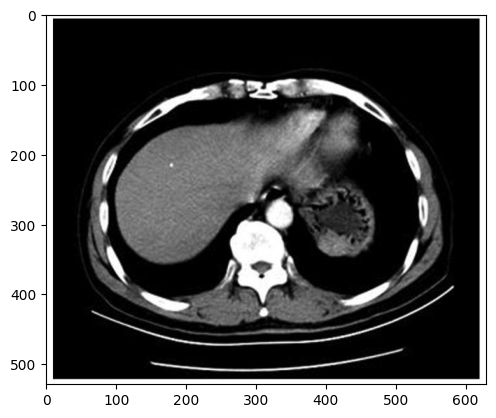

In [16]:
# image = Image.open("./examples/5.jfif").convert("RGB")
sample = test_split[0]
image = sample['image'].convert("RGB")
image_pre = preprocess(image)

text = "intravascular coagulation manifestation"
# text = sample['caption']

image_input = torch.tensor(np.expand_dims(image_pre, axis=0)).to(device)
text_tokens  = tokenizer(text).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

    # Normalize -> cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)

    # Similarity scores 
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

plt.imshow(image)
print("Text:", text)
print("Similarity:", similarity)

## Save checkpoint


In [17]:
# Save
out_dir = './model'
os.makedirs(out_dir, exist_ok=True)
ckpt_path = os.path.join(out_dir, 'openclip_vitb32.pt')
torch.save({
    'state_dict': model.state_dict(), 
    'model_name': model_name, 
    'pretrained': pretrained
}, ckpt_path)
print(f"Saved model to {ckpt_path}")

Saved model to ./model\openclip_vitb32.pt


## Reload later

```python
import torch, open_clip
ckpt = torch.load('openclip_finetuned_food101/openclip_vitb32_food101.pt', map_location='cpu')
model, _, preprocess = open_clip.create_model_and_transforms(ckpt['model_name'], pretrained=ckpt['pretrained'])
model.load_state_dict(ckpt['state_dict'])
model.eval()
```
